<a href="https://colab.research.google.com/github/Sammy-Reeves/Issue-2-electric-bagaloo/blob/main/Week_3_Time_Series/1_Average_NDI_Through_Time(CARRandZOG).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Calculate the average NDI over a sample area through time

## Log in to Google Earth Engine

As usual, we will import our packages and log in to Google Earth Engine. Note that we are exporting from some new packages this week - `pandas`, `matplotlib.pyplot`, and `google.colab`'s `drive`. `pandas` is a package for dealing with tabular data - think of it as Python's version of Microsoft Excel. `matplotlib` is Python's go-to plotting library for making graphs and figures (so far, we've been doing it all with Google Earth Engine, but now this week we'll plot directly in Python). The `google.colab` package is unique to working within Google Colaboratory - `drive` will allow us to connect directly to our Google Drive and export tabular data as, for instance, a csv or excel file.

As always, make sure to replace the `project` name with your own in the `ee.Initialize` function.


In [31]:
import ee
import geemap
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive

ee.Authenticate()  # Trigger the authentication flow.
ee.Initialize(project='ee-sammyreeveswork')    # Change to your own default project name.

## Identify region and NDI of interest

We'll frontload our choices this week - setting out lat/lon, location name, sample area, and the type of NDI early.

Note that this week, we will not be setting a large area to assess an image, but a smaller plot of land. I've set a 500 m radius here, but this could easily be larger - for example, 1000-2000 m. The important that is that this area represents a _sample_ of a single surface type, so the sample surface should be _homogenous_ (e.g. entirely a forest). I have chosen an spot of forest in Northern California near the town of Hoopa - you will see why later.

A great example to show time-series over is NDVI over decidious vegetation, so that is what we will do this week. Note that I have set the NDI settings from last week here as well - NDVI requires an $R_{high}$ in the near infrared (band 5), and an $R_{low}$ in the red (band 4), so that is what I have done below.

In [32]:
# Location - editable
latitude = 40.53927   # Degrees of latitude
longitude = -122.56656  # Degrees of longitude
location_name = 'CarrANDZogg'  # recognisable name, to create a useful file name
sample_radius = 1000         # radius of sample area around chosen point, in metres

# NDI - editable
type_of_ndi = 'NDVI'  # type of NDI calculated, for filename purposes
r_high = 'B5'  # relevant band name for r_high
r_low = 'B4'   # relevant band name for r_low

# Set up location geometry
point = ee.Geometry.Point(longitude, latitude)  # Create a point
sample_region = point.buffer(sample_radius)     # Buffer the point


Running the below cell will visualise the sample region. If you would like to ensure you are sampling a consistent surface, you can bring up a quick Landsat layer by clicking 🔧 > 🌐. The layer will appear on top of the search region so you might have to toggle the Landsat layer on and off to get a good idea of what is going on.

In [33]:
Map = geemap.Map()  # Create an empty Map
Map.addLayer(sample_region, {}, "Search Region")  # Add our AOI
Map.centerObject(sample_region, zoom=12)  # Centre our map on the region of interest
Map

Map(center=[40.539271025886286, -122.56655996257403], controls=(WidgetControl(options=['position', 'transparen…

Finally, we will get the complete Landsat 8 record over the sample region. I do not filter by date - we will do that later - but I do a couple of things to filter cloudy pixels. The first is to filter by the `CLOUD_COVER` metadata only to images that have less then 70% cloud cover within an image. The second, which is slightly more complex, uses the `.map()` function. This is a new feature that will allow us to apply a processing routine to every individual image within the image collection. the `lambda image:` tells Python "_as you go through the image collection, we will pretend that every individual image has the variable name_ `image`_. Then, perform the calculation to the right of the colon to every_ `image`_._"

Don't worry about the details of the lambda function. It takes advantage of Earth Engine's built in `simpleCloudScore` function. This assigns a probability to every single pixel that the image is cloud. I use this to _mask_ the images only to pixels that have a <20% chance of being cloud. Later in the notebook, we will be calculating the median NDVI value within the sample region - masking the cloudy pixels ensures we aren't also including the NDVI of cloudy regions within the median value. Clouds are the bane of optical remote sensors!

In [34]:
# Get Landsat 8 image collection
landsat8_collection = ee.ImageCollection("LANDSAT/LC08/C02/T1_TOA")

# Filter to desired region and date bounds
landsat8_collection = landsat8_collection.filterBounds(sample_region)
landsat8_collection = landsat8_collection.sort('system:time_start')  # Sort by image date
landsat8_collection = landsat8_collection.filter(ee.Filter.lt('CLOUD_COVER', 70))

# Filter cloudy pixels within the images
landsat8_collection = landsat8_collection.map(
    lambda image: image.updateMask(ee.Algorithms.Landsat.simpleCloudScore(image).select(['cloud']).lte(20))
)

landsat8_collection

Now that we have our cloud-masked image collection, I will show you three different ways we could extract a time-series of NDVI values within the sample region. They are subtly different but may have different uses to you within your project. If you think you aren't being served by the examples I've shown here, then feel free to ask me what you might want - if it's achievable, I'd be happy to write a new script that could extract the data you desire for your project.

The three time-series we're going to extract are as follows. I'm going to refer to them as follows, although they aren't formal names:

1. __Mean monthly NDI__: Average January-December NDI values across a number of years (e.g. January 2013-23, February 2013-23, `...`, December 2013-23).
2. __Time-series mean monthly NDI__: Average monthly NDI values between two time periods (e.g. January 2013, February 2013, `...`, December 2023).
3. __Time-series mean seasonal NDI__: Average NDI values over a set period, every year (e.g. June-August 2013, June-August 2014, `...`, June-August 2023).

## Mean monthly NDI

The first of our time-series requires only two input variables to be set: the beginning an end year we wish to collect the mean monthly NDI over. I have set this as a standard between 2014 and 2023. Although Landsat data exists for 2013, it didn't launch untill the 11th February. As a result, it will not have consistent data for the whole of 2013, and it is best to collect annual datasets from 2014 onwards.

You might wish to consider breaking up this timespan for your project. For instance, maybe there is a difference between the seasonal NDI variation between 2014-2018 and 2019-2023 following some sort of human interference?

In [35]:
year_begin = 2020
year_end = 2021

Now we'll get to the nuts and bolts of the time-series extraction. Once again, you don't have to edit this or worry about the details, although you might be interested in the process. First, we create an empty `pandas` DataFrame (read: a table, like you would create in Excel) with "month" and "NDVI" columns (we get the "NDVI" name from the `type_of_ndi` variable, which we set above. This means that were you run with another type - such as NDWI - the column will be named correctly automatically).

After this, we begin a 'loop'. In Python, means we iterate through a list, running the same instructions on every one. For instance, the instruction

```python
for i  in [1, 2, 3, 4, 5]:
    print(i)
```
Would `print` the numbers `1` to `5` in order. In the cell below, we loop through the numbers `1` through `12` as the `month` variable, `filter`ing our Landsat 8 collection to only that month. If there's no images that month (not impossible), we return `None`. Else, we perform another `map`function, calculating our NDI using the `normalizedDifference` function to calculate the NDI for every image that month based on the `r_high` and `r_low` we set above. We then use the `.median()` function to produce a single composite image that is constructed as the median value from every image in the month. We use a `reduceRegion()` function to calculate the average value in our sample region in this composite image. Finally, we populate our table with this value, before starting again in the next month.

Of course, you don't need to worry about all this - just run the cell and see what happens!

In [36]:

# Create an empty table with the columns ('month' and 'ndi')
monthly_ndi_record = pd.DataFrame({'month': [], type_of_ndi: []})

# Filter record to years
filtered_collection = landsat8_collection.filter(ee.Filter.calendarRange(year_begin, year_end, 'year'))

# Simple 'loading bar' showing the months
print('Month:  JFMAMJJASOND\n        ', end='')

# Loop through months, calculating the mean NDI within the region of interest
for month in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]:  # for every month in the range 1 through 12...
    print('.', end='')  # Add a point on the 'loading bar'

    # Filter images only to those within the chosen month
    month_images = filtered_collection.filter(ee.Filter.calendarRange(month, month, 'month'))

    # If there are no available images, return 'NaN' ('not a number'; blank).
    if month_images.size().getInfo() == 0:
        mean_ndi = None

    # Else (i.e. if there *are* images...)
    else:
        # Calculate NDI for every image in the image collection (this is called 'mapping')
        month_ndis = month_images.map(lambda image: image.normalizedDifference([r_high, r_low]).rename(type_of_ndi))

        # Calculate a composite NDI image by calculating the median through the image collection
        month_ndi = month_ndis.median()

        # Calculate the average NDI of the composite image within the region of interest
        mean_ndi = month_ndi.reduceRegion(reducer=ee.Reducer.mean(), geometry=sample_region, scale=30).getInfo()[type_of_ndi]

    # Add a row to the table containing the relevant data
    df = pd.DataFrame({'month': [int(month)], type_of_ndi: [mean_ndi]})
    monthly_ndi_record = pd.concat([monthly_ndi_record, df])

# DataFrame wrangling to correct errors introduced by concatenating records.
monthly_ndi_record = monthly_ndi_record.reset_index().drop(columns='index')

# Print 'finished' when we're finished calculating
print('\n        Finished!')

Month:  JFMAMJJASOND
        ............
        Finished!


Now that we have the data in a `pandas` DataFrame (a table), we can view the data as such:

In [37]:
monthly_ndi_record

,month,NDVI
0,1.0,0.280258
1,2.0,0.391093
2,3.0,0.343879
3,4.0,0.475173
4,5.0,0.468924
5,6.0,0.451476
6,7.0,0.410934
7,8.0,0.309527
8,9.0,0.362694
9,10.0,0.259657


This DataFrame also has some nice plotting functions, which we can use in combination with the Python `matplotlib` package to create a graph of our data:

Text(0, 0.5, 'NDVI')

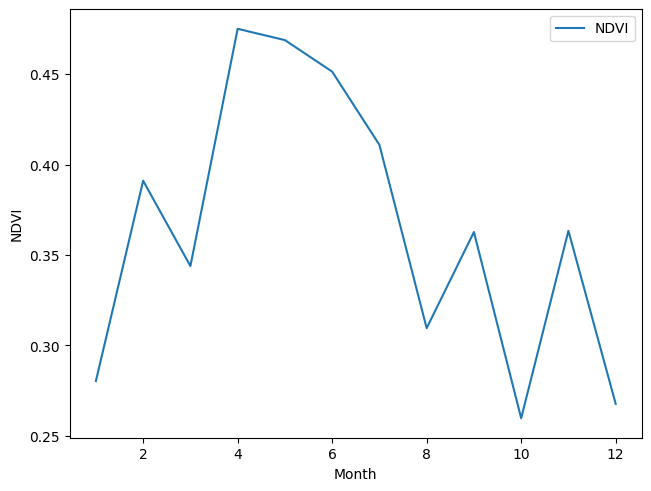

In [38]:
# create an empty figure
fig, ax = plt.subplots(layout='constrained')

# plot the NDI record from the pandas DataFrame
monthly_ndi_record.plot('month', type_of_ndi, ax=ax)

# Set the x and y labels
ax.set_xlabel('Month')
ax.set_ylabel(type_of_ndi)

This NDVI variation makes sense for a deciduous forest: lower in the winter, and higher in the summer.

> **Note:** You do not have to worry about being able to plot graphs in Python (unless you feel like learning about it, of course!). At the end of the notebook, we will export these data to your Google Drive as a .csv file, which means you can display the graphs in a software of your choice (Excel, etc.) for your final project. If you feel like learning, LLM AI tools, such as ChatGPT or Google Bard, are a great way to help you learn coding skills. Just ask them what you should do, provide sample code, and give them any errors if things go wrong!

## Time-series mean monthly NDI

In the section above, we calculate average NDI values for every month based on all years. However, we can also go month-by-month, producing a time-series of NDI behaviour.

This is slightly more time-consuming, so for now we will choose a slightly smaller range of years -- 2020 and 2023. You could go all out and set 2013 and 2023 if you like, or just set both years the same (e.g. 2020 and 2020) if you'd only like a single year.

In [39]:
year_begin = 2017
year_end = 2022

The cell below is largely similar to the section above, but notice this time we have two loops: `for year in [years]` and `for month in [months]`. This means we go through ever year in our temporal range, then every month in every one of those years...

In [40]:

# Create an empty table with the relevant columns ('date' and 'ndi')
timeseries_ndi_record = pd.DataFrame({'date': [], type_of_ndi: []})

# Simple 'loading bar'
print('Year    JFMAMJJASOND')

# Loop through years and months, calculating the mean NDI within the region of interest

for year in list(range(year_begin, year_end+1)): # For every year in the range year_begin to year_end...
    print(f'{year}    ', end='')  # Another 'loading bar' component

    for month in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]:  # For every month in the range 1 to 12...
        print('.', end='')  # Another 'loading bar' component

        # Filter images only to those within the chosen month
        month_start = f'{year}-{month}-01'
        month_end = f'{year}-{month+1}-01' if month != 12 else f'{year+1}-01-01'
        month_images = landsat8_collection.filterDate(month_start, month_end)

        # If there are no available images, return 'NaN' ('not a number'; blank).
        if month_images.size().getInfo() == 0:
            mean_ndi = None

        # Else (i.e. if there *are* images...)
        else:
            # Calculate NDI for every image in the image collection (this is called 'mapping')
            month_ndis = month_images.map(lambda image: image.normalizedDifference([r_high, r_low]).rename(type_of_ndi))

            # Calculate a composite NDI image by calculating the median through the image collection
            month_ndi = month_ndis.median()

            # Calculate the average NDI of the composite image within the region of interest
            mean_ndi = month_ndi.reduceRegion(reducer=ee.Reducer.mean(), geometry=sample_region, scale=30).getInfo()[type_of_ndi]

        df = pd.DataFrame({'date': [pd.to_datetime(f'{year}-{month}-15')], type_of_ndi: [mean_ndi]})
        timeseries_ndi_record = pd.concat([timeseries_ndi_record, df])
    print('')

print('Finished!')

Year    JFMAMJJASOND
2017    ............
2018    ............
2019    ............
2020    ............
2021    ............
2022    ............
Finished!


See what this looks like as a DataFrame:

In [41]:
timeseries_ndi_record

,date,NDVI
0,2017-01-15,0.539429
0,2017-02-15,NaN
0,2017-03-15,0.591704
0,2017-04-15,0.625789
0,2017-05-15,0.667061
...,...,...
0,2022-08-15,0.377381
0,2022-09-15,0.363308
0,2022-10-15,0.393433
0,2022-11-15,0.381712


Note that, as we assign a nominal date to the images, they are set to be the 15th of every month. Just remember that this actually represents a monthly average.

And we can plot it:

Text(0, 0.5, 'NDVI')

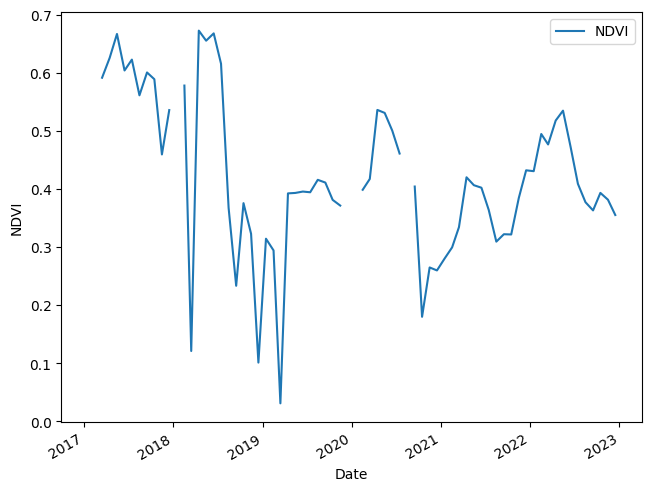

In [42]:
# create an empty figure
fig, ax = plt.subplots(layout='constrained')

# plot the NDI record from the pandas DataFrame
timeseries_ndi_record.plot('date', type_of_ndi, ax=ax)

# Set the x and y labels
ax.set_xlabel('Date')
ax.set_ylabel(type_of_ndi)

Notice that our dataset isn't quite as pretty as before. Theoretically, we can get a Landsat image every two weeks (and more so as we get closer to the poles, as the satellite tracks begin to converge and parallel images begin to overlap). However, cloud is a big problem: if there are only a few scenes in a month, then there is a likelihood that a lot of these scenes are cloud-covered.

It will be up to your to critically assess your data in your project. Is a spike in your data likely real or an anomaly? This is important to explicitly discuss when weighing up the strengths of your conclusions in your project report.

For instance, in the dataset above it is unlikely that the single-month large negative spikes are realistic. However, the large decline from July 2023? Those are the [visible effects of wildfires](https://www.times-standard.com/2023/08/19/hoopa-area-fire-more-than-doubles-in-size-as-another-storm-system-moves-in/)! In your project, hopefully you are motivated to assess known events. A wildfire project might involve using the week 2 script to quantify the areal extent of a wildfire, and the time-series to track recovery rates.

## Time-series mean seasonal NDI

For the final method, we are going to extract a single NDI value per year. However, we will extract this value over a number of months. In the cell below, we set our `month_begin` and `month_end` value to 8 (August) and 10 (October) respectively. This will allow us to assess NDVI over the post-summer months, which hopefully might reveal wildfire years. However, you could just as easily set the values to 1 and 12 to assess mean NDVI over the entire year, or 10 and 10 to assess only over October (for example).

In [43]:
year_begin = 2014
year_end = 2023

month_begin = 8
month_end = 10

The cell below will look familiar by this point, with some minor changes (try and find them if you like, and think about what they are doing).

In [44]:

# Create an empty table with the relevant columns ('year' and 'ndi')
seasonal_ndi_record = pd.DataFrame({'year': [], type_of_ndi: []})

# Simple 'loading bar'
print('Year')

# Loop through years, calculating the mean NDI within the region of interest

for year in list(range(year_begin, year_end+1)): # For every year in the range year_begin to year_end...
    print(f'{year}... ', end='')  # Another 'loading bar' component

    # Filter images only to those within the chosen month and year
    month_images = landsat8_collection.filter(ee.Filter.calendarRange(month_begin, month_end, 'month')).filter(ee.Filter.calendarRange(year, year, 'year'))

    # If there are no available images, return 'NaN' ('not a number'; blank).
    if month_images.size().getInfo() == 0:
        mean_ndi = None

    # Else (i.e. if there *are* images...)
    else:
        # Calculate NDI for every image in the image collection (this is called 'mapping')
        month_ndis = month_images.map(lambda image: image.normalizedDifference([r_high, r_low]).rename(type_of_ndi))

        # Calculate a composite NDI image by calculating the median through the image collection
        month_ndi = month_ndis.median()

        # Calculate the average NDI of the composite image within the region of interest
        mean_ndi = month_ndi.reduceRegion(reducer=ee.Reducer.mean(), geometry=sample_region, scale=30).getInfo()[type_of_ndi]

    df = pd.DataFrame({'year': [year], type_of_ndi: [mean_ndi]})
    seasonal_ndi_record = pd.concat([seasonal_ndi_record, df])

print('Finished!')

Year
2014... 2015... 2016... 2017... 2018... 2019... 2020... 2021... 2022... 2023... Finished!


This gives us our final record:

In [45]:
seasonal_ndi_record

,year,NDVI
0,2014.0,0.617540
0,2015.0,0.570847
0,2016.0,0.627739
0,2017.0,0.587488
0,2018.0,0.372122
0,2019.0,0.412899
0,2020.0,0.314524
0,2021.0,0.314211
0,2022.0,0.381828
0,2023.0,0.474425


Which we can plot again:

Text(0, 0.5, 'NDVI')

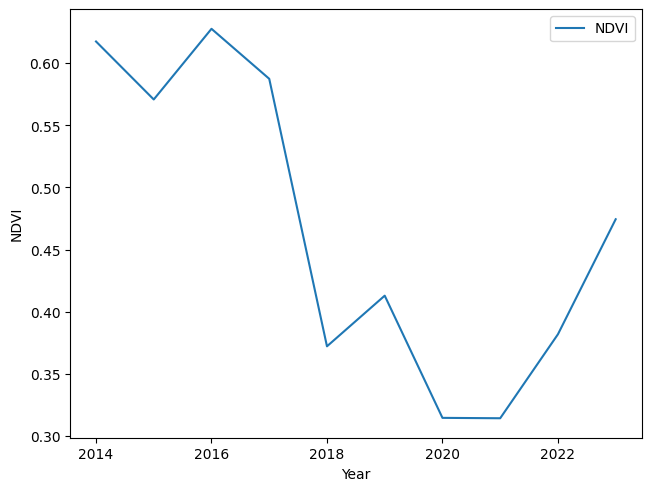

In [46]:
# create an empty figure
fig, ax = plt.subplots(layout='constrained')

# plot the NDI record from the pandas DataFrame
seasonal_ndi_record.plot('year', type_of_ndi, ax=ax)

# Set the x and y labels
ax.set_xlabel('Year')
ax.set_ylabel(type_of_ndi)

Looks like there was significant low NVDVI between August-October in 2021 and 2023. Were these significant wildfire years? This makes sense. 2020 was known in the media for being a [significant wildfire year](https://www.nytimes.com/interactive/2020/09/24/climate/fires-worst-year-california-oregon-washington.html), and we already know that one occurred in 2023. In a project report, we would back up this with published data, including scientific articles and government reports!

Note that expanding our range from a monthly assessment to a seasonal assessment gives us more images to draw from, increase chance we obtain consistent, reliable sample.

## Export data as `.csv` files to Google Drive

Now, we must export our data to Google Drive. We will do this slightly differently to previously - before, we were telling Google Earth Engine to export data to our Google Drive. Now, we have our data with us as `pandas` DataFrames, which have their own export function.

First, we must 'mount' our Google Drive onto the Google Colab. This is done using the custom `drive.mount()` function.

In [47]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Now, we can proceed as though our Google Drive is part of the current filesystem.

First, choose a top-level directory to set as your export location. For now, I've kept it the same as previous weeks, although you are free to change this if you wish.

In [48]:
# You can edit this variable
folder = 'scires_project_2A'

Then, we can export our data using the `pandas` DataFrame `.to_csv()` function. As in previous weeks, I have set the filename to generate automatically based on the location name we have set at the top of the notebook.

In [49]:
# Construct the filename automatically
filename = location_name + f'_landsat_8_{year_begin}_{year_end}_monthly_ndi.csv'

# Print out filename for reference
print("The image will be saved to your Google Drive at:\n" + folder + '/' + filename + '\n')

# Export the pandas dataframe to a csv file
monthly_ndi_record.to_csv(f'/content/drive/My Drive/{folder}/{filename}', index=False)

print('Saved.')

The image will be saved to your Google Drive at:
scires_project_2A/CarrANDZogg_landsat_8_2014_2023_monthly_ndi.csv

Saved.


Note that, compared to Google Earth Engine, this is a lot quicker. This is because we're just exporting a very small text file, rather than processing and exporting large images!

The next two cells will export the other two time-series we have constructed.

In [50]:
# Construct the filename automatically
filename = location_name + f'_landsat_8_{year_begin}_{year_end}_timeseries_ndi.csv'

# Print out filename for reference
print("The image will be saved to your Google Drive at:\n" + folder + '/' + filename + '\n')

# Export the pandas dataframe to a csv file
timeseries_ndi_record.to_csv(f'/content/drive/My Drive/{folder}/{filename}', index=False)

print('Saved.')

The image will be saved to your Google Drive at:
scires_project_2A/CarrANDZogg_landsat_8_2014_2023_timeseries_ndi.csv

Saved.


In [51]:
# Construct the filename automatically
filename = location_name + f'_landsat_8_{year_begin}_{year_end}_seasonal_ndi.csv'

# Print out filename for reference
print("The image will be saved to your Google Drive at:\n" + folder + '/' + filename + '\n')

# Export the pandas dataframe to a csv file
seasonal_ndi_record.to_csv(f'/content/drive/My Drive/{folder}/{filename}', index=False)

print('Saved.')

The image will be saved to your Google Drive at:
scires_project_2A/CarrANDZogg_landsat_8_2014_2023_seasonal_ndi.csv

Saved.


Check your Google Drive to confirm they have appeared. You can now open them in software of your choosing. Unlike previously, this week won't include a section on analysing these data. I will leave it up to you how you might wish to analyse these data for your project (if you choose to use this approach). It might be as simple as presenting them as a graph in Excel -- or you might wish to perform a statistical test, such as a linear regression, to show change over time. If you're at a loss, things might be clearer next week, when we download and visualise complementary climate records.